In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import pandas as pd
import camb
import astroquery
import healpy
import astropy.units as u
import sympy
import reproject
import treecorr
import Corrfunc
import math
from astropy.io import fits
from astropy.wcs import WCS
# %matplotlib inline
import healpy as hp
import scipy
import pymaster
import stilts_wrapper
import sys
import os
# import scipy.stats._rvs_sampling

In [2]:
catalogue=astropy.io.fits.open("../Data/XG_IDR2_4Parts_170-231MHz_comp_rescaled.fits")
catalogue_data=catalogue[1].data
catalogue_columns=catalogue[1].columns
catalogue_csv=pd.read_csv("../Data/XG_IDR2_4Parts_170-231MHz_comp_rescaled.csv")
image=astropy.io.fits.open("../Data/XG_IDR2_4Parts_170-231MHz_rescaled.fits")
image_data=image[0].data
positions=astropy.coordinates.SkyCoord(catalogue_csv.iloc[:,6],catalogue_csv.iloc[:,8],unit=u.deg)
rms=astropy.io.fits.open("../Data/XG_IDR2_4Parts_170-231MHz_rms.fits")
rms_data=rms[0].data

## Preamble

In [3]:
left_ra=83
right_ra=339
max_dec=-10
min_dec=-30

In [4]:
area=(image[0].header['NAXIS1']*abs(image[0].header['CDELT1']))*(image[0].header['NAXIS2']*abs(image[0].header['CDELT2']))
area_steradian=((np.pi/180)**2)*area
area_steradian
count=0
set_flux=0.1
for i in range(0,len(catalogue_csv)):
	if catalogue_csv.loc[i,'int_flux']-catalogue_csv.loc[i,'local_rms']<set_flux:
		count=count+1
	elif catalogue_csv.loc[i,'int_flux']+catalogue_csv.loc[i,'local_rms']>set_flux:
		count=count+1
amount=count
constant_of_intergration=(amount/area_steradian)-(6998/-0.54)*(set_flux)**(-0.54)
constant_of_intergration
lower_limit=0.001
upper_limit=100
x=sympy.symbols('x')
total=sympy.integrate(6998*(x)**(-1.54),(x,0.001,100))
def S_dist(N):
	return (-0.54*(N-constant_of_intergration)*total/6998)**(1/-0.54)
def N_dist(s):
	return constant_of_intergration+6998*(1/total)*(1/-0.54)*(s)**-0.54

In [5]:
vals,bins,patches=plt.hist(catalogue_csv['peak_flux'],np.logspace(-3,np.log10(max(catalogue_csv.loc[:,'peak_flux'])),50),log=True,histtype='step',label='catalogue_peak_flux',density=True,cumulative=True)
# vals,bins,patches=np.histogram(catalogue_csv['peak_flux'],np.logspace(-3,np.log10(max(catalogue_csv.loc[:,'peak_flux'])),50),log=True,histtype='step',label='catalogue_peak_flux',density=True,cumulative=True)
def prob_summer_2(number):
	random_numbers=np.random.uniform(0,1,number)
	CDF_numpy=np.zeros((len(bins)-1,2))
	CDF_numpy[:,0]=bins[:-1]
	CDF_numpy[:,1]=vals
	index_values=np.searchsorted(CDF_numpy[:,1],random_numbers,side='right')
	S_values=CDF_numpy[index_values,0]
	return S_values
plt.close()

In [6]:
lower_N=N_dist(lower_limit)
upper_N=N_dist(upper_limit)
rand_ra=np.random.uniform(0,360,1*10**8)
rand_sindec = np.random.uniform(-1, 1,1*10**8)
rand_dec = np.arcsin(rand_sindec)
rand_dec=rand_dec*180/np.pi
rand_fluxes=prob_summer_2(10**8)
rand_dict={'ra':rand_ra,'dec':rand_dec,'flux':rand_fluxes}
rand_dataframe=pd.DataFrame(rand_dict,dtype=float)
# del rand_dict,rand_ra,rand_dec,rand_sindec,rand_fluxes
rand_dataframe.reset_index(drop=True,inplace=True)
# rand_dataframe.to_csv('./Data/10_8_rand_fluxes.csv')

In [7]:
np.std(rand_fluxes)

0.8395239059347808

In [8]:
RA_LIMITS=(right_ra,left_ra)
DEC_LIMITS=(min_dec, max_dec)

dec_mask = (DEC_LIMITS[0] < rand_dataframe.dec) & (rand_dataframe.dec < DEC_LIMITS[1])

if RA_LIMITS[0] < RA_LIMITS[1]:
    ra_mask = (RA_LIMITS[0] <= rand_dataframe.ra) & (rand_dataframe.ra < RA_LIMITS[1])
else:
    ra_mask = (rand_dataframe.ra <= RA_LIMITS[1]) | (RA_LIMITS[0] < rand_dataframe.ra)
    

random_mask = dec_mask & ra_mask

In [9]:
RA_LIMITS=(right_ra,left_ra)
DEC_LIMITS=(min_dec, max_dec)

dec_mask = (DEC_LIMITS[0] < catalogue_csv.dec) & (catalogue_csv.dec < DEC_LIMITS[1])

if RA_LIMITS[0] < RA_LIMITS[1]:
    ra_mask = (RA_LIMITS[0] <= catalogue_csv.ra) & (catalogue_csv.ra < RA_LIMITS[1])
else:
    ra_mask = (catalogue_csv.ra <= RA_LIMITS[1]) | (RA_LIMITS[0] < catalogue_csv.ra)
    

cat_mask = dec_mask & ra_mask

In [10]:
rand_dataframe_subset=rand_dataframe[random_mask]
cat_dataframe_subset=catalogue_csv[cat_mask]

In [11]:
# rand_dataframe_subset['local_rms']=np.nan
positions_rands=astropy.coordinates.SkyCoord(rand_dataframe_subset['ra'],rand_dataframe_subset['dec'],unit=u.deg,frame='icrs')

In [12]:
wcs_RMS=WCS(rms[0].header)
wcs_image=WCS(image[0].header)
rms_pixel_x,rms_pixel_y=wcs_RMS.world_to_pixel(positions_rands)
rms_pixel_x=np.int64(rms_pixel_x)
rms_pixel_y=np.int64(rms_pixel_y)
rand_dataframe_subset['x_pixel_int']=rms_pixel_x
rand_dataframe_subset['y_pixel_int']=rms_pixel_y
# rand_dataframe_subset
rand_dataframe_subset=rand_dataframe_subset[rand_dataframe_subset['x_pixel_int']<rms[0].header['NAXIS1']]
rand_dataframe_subset=rand_dataframe_subset[rand_dataframe_subset['y_pixel_int']<rms[0].header['NAXIS2']]
# rand_dataframe_subset

/tmp/ipykernel_77254/3110186155.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_dataframe_subset['x_pixel_int']=rms_pixel_x
/tmp/ipykernel_77254/3110186155.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_dataframe_subset['y_pixel_int']=rms_pixel_y


In [13]:
rand_dataframe_subset['local_rms']=rms_data[rand_dataframe_subset['y_pixel_int'],rand_dataframe_subset['x_pixel_int']].astype(float)
# rand_dataframe_subset

In [14]:
rand_dataframe_cut=rand_dataframe_subset.copy(deep=True)
# rand_dataframe_cut['noise_multer']=np.sign(np.random.uniform(-1,1,len(rand_dataframe_cut)))
rand_dataframe_cut['measured_flux']=rand_dataframe_cut['flux']+(np.random.normal(0,rand_dataframe_cut['local_rms'],len(rand_dataframe_cut)))
rand_dataframe_cut['flux_sigma_ratio']=rand_dataframe_cut['measured_flux']/rand_dataframe_cut['local_rms']
mask=rand_dataframe_cut['flux_sigma_ratio']>=5
rand_dataframe_cut=rand_dataframe_cut[mask]
rand_dataframe_cut.reset_index(drop=True,inplace=True)
rand_dataframe_cut_10=rand_dataframe_cut
cat_dataframe_subset_10_cut=cat_dataframe_subset
# rand_dataframe_cut_10.to_csv('../Data/rand_dataframe_new_small_area_ang_power_spectrum_new_healpix_experimentation.csv')
# rand_dataframe_subset.to_csv('../Data/rand_dataframe_new_small_area_ang_power_spectrum_new_healpix_experimentation_no_noise.csv')
# cat_dataframe_subset_10_cut.to_csv('../Data/cat_dataframe_new_small_area_ang_power_spectrum_new_healpix_experimentation.csv')

In [15]:
len(rand_dataframe_subset)-len(rand_dataframe_cut_10)

399043

## Healpix creation, importing

In [16]:
# Test=stilts_wrapper.Stilts("tcopy",in_='XG_IDR2_4Parts_170-231MHz_comp_rescaled.fits',ifmt='fits',ofmt='fits',out_='Test.fits')
# Test.run()

In [17]:
rand_dataframe_cut_10['count_column']=1
rand_dataframe_subset['count_column']=1
cat_dataframe_subset_10_cut['count_column']=1
rand_dataframe_cut_10.to_csv('../Data/rand_dataframe_new_small_area_ang_power_spectrum_new_healpix_experimentation.csv')
rand_dataframe_subset.to_csv('../Data/rand_dataframe_new_small_area_ang_power_spectrum_new_healpix_experimentation_no_noise.csv')
cat_dataframe_subset_10_cut.to_csv('../Data/cat_dataframe_new_small_area_ang_power_spectrum_new_healpix_experimentation.csv')

/tmp/ipykernel_77254/4027824656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_dataframe_subset_10_cut['count_column']=1


In [18]:
# os.system('stilts tskymap lon=ra lat=dec ocmd="healpixmeta -csys C" cols=count_column in=/home/brandon/PHD/Data/cat_dataframe_new_small_area_ang_power_spectrum_new_healpix_experimentation.csv ifmt=csv tiling=hpx7 combine=count-per-unit complete=true out=/home/brandon/PHD/Data/cat_C_l_healpix.fits ofmt=fits-healpix perunit=degree2')
# os.system('stilts tskymap lon=ra lat=dec ocmd="healpixmeta -csys C" cols=count_column in=/home/brandon/PHD/Data/rand_dataframe_new_small_area_ang_power_spectrum_new_healpix_experimentation.csv ifmt=csv tiling=hpx7 combine=count-per-unit complete=true out=/home/brandon/PHD/Data/rand_C_l_healpix_count_per_unit.fits ofmt=fits-healpix perunit=degree2')
# os.system('stilts tskymap lon=ra lat=dec ocmd="healpixmeta -csys C" cols=count_column in=/home/brandon/PHD/Data/rand_dataframe_new_small_area_ang_power_spectrum_new_healpix_experimentation.csv ifmt=csv tiling=hpx7 combine=count complete=true out=/home/brandon/PHD/Data/rand_C_l_healpix_count.fits ofmt=fits-healpix')
# os.system('stilts tskymap lon=ra lat=dec ocmd="healpixmeta -csys C" cols=count_column in=/home/brandon/PHD/Data/rand_dataframe_new_small_area_ang_power_spectrum_new_healpix_experimentation_no_noise.csv ifmt=csv tiling=hpx7 combine=count complete=true out=/home/brandon/PHD/Data/rand_C_l_healpix_no_noise_count.fits ofmt=fits-healpix')
# os.system('stilts tskymap lon=ra lat=dec ocmd="healpixmeta -csys C" cols=local_rms in=/home/brandon/PHD/Data/rand_dataframe_new_small_area_ang_power_spectrum_new_healpix_experimentation.csv ifmt=csv tiling=hpx7 combine=mean complete=true out=/home/brandon/PHD/Data/rand_C_l_healpix_mean_noise.fits ofmt=fits-healpix')

In [19]:
# cat_map=hp.fitsfunc.read_map('/home/brandon/PHD/Data/cat_C_l_healpix.fits',field=1,nest=True)
# rand_map=hp.fitsfunc.read_map('/home/brandon/PHD/Data/rand_C_l_healpix_count_per_unit.fits',field=1,nest=True)
# rand_map_count=hp.fitsfunc.read_map('/home/brandon/PHD/Data/rand_C_l_healpix_count.fits',field=1,nest=True)
# rand_map_no_noise_count=hp.fitsfunc.read_map('/home/brandon/PHD/Data/rand_C_l_healpix_no_noise_count.fits',field=1,nest=True)
# rand_map_mean_noise=hp.fitsfunc.read_map('/home/brandon/PHD/Data/rand_C_l_healpix_mean_noise.fits',field=1,nest=True)

In [20]:
# cat_map=hp.pixelfunc.reorder(cat_map,inp='NESTED',out='RING')
# rand_map=hp.pixelfunc.reorder(rand_map,inp='NESTED',out='RING')
# hp.fitsfunc.write_map('../Data/cat_C_l_healpix_ring.fits',cat_map,overwrite=True)

In [21]:
cat_map=hp.fitsfunc.read_map('../Data/cat_data_new_area_healpix_level_7.fits',nest=True,h=True)
cat_map=hp.fitsfunc.read_map('../Data/cat_data_new_area_healpix_level_7_new.fits',nest=True,h=True)
#,nest=True)
# cat_map=astropy.io.fits.open('../Data/cat_data_new_area_healpix_level_7.fits',nest=True)
rand_map=hp.fitsfunc.read_map('../Data/rand_data_new_area_healpix_level_7.fits',h=True,nest=True)#,nest=True)
rand_map=hp.fitsfunc.read_map('/home/brandon/PHD/Data/rand_C_l_healpix_count_per_unit_topcat_derived.fits',h=True,nest=True)#,nest=True)
rand_map_count=hp.fitsfunc.read_map('/home/brandon/PHD/Data/rand_C_l_healpix_count_topcat_derived.fits',h=True,nest=True)#,nest=True)
rand_map_no_noise_count=hp.fitsfunc.read_map('/home/brandon/PHD/Data/rand_C_l_healpix_count_no_noise_topcat_derived.fits',h=True,nest=True)#,nest=True)
rand_map_mean_noise=hp.fitsfunc.read_map('/home/brandon/PHD/Data/rand_C_l_healpix_mean_noise_topcat_derived.fits',h=True,nest=True)
# hp.fitsfunc.write_map('../Data/cat_map_test.fits',cat_map,overwrite=True)

/home/brandon/anaconda3/lib/python3.9/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/brandon/anaconda3/lib/python3.9/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 128
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/brandon/anaconda3/lib/python3.9/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/brandon/anaconda3/lib/python3.9/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = EXPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [55]:
cat_map

(array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
        -1.6375e+30, -1.6375e+30]),
 [('XTENSION', 'BINTABLE'),
  ('BITPIX', 8),
  ('NAXIS', 2),
  ('NAXIS1', 12),
  ('NAXIS2', 9497),
  ('PCOUNT', 0),
  ('GCOUNT', 1),
  ('TFIELDS', 2),
  ('PIXTYPE', 'HEALPIX'),
  ('NSIDE', '128'),
  ('ORDERING', 'NESTED'),
  ('COORDSYS', 'C'),
  ('INDXSCHM', 'EXPLICIT'),
  ('OBS_NPIX', '9497'),
  ('OBJECT', 'PARTIAL'),
  ('TTYPE1', 'PIXEL'),
  ('TFORM1', 'J'),
  ('TCOMM1', 'HEALPix pixel index'),
  ('TTYPE2', 'density'),
  ('TFORM2', 'D'),
  ('TUNIT2', '1/deg**2'),
  ('TCOMM2', 'Number of items counted per square degree'),
  ('TUCD2', 'src.density'),
  ('DATE-HDU', '2022-06-16T05:41:34'),
  ('STILVERS', '4.0-5'),
  ('STILCLAS', 'uk.ac.starlink.fits.HealpixFitsTableWriter')])

In [22]:
NSIDE = hp.get_nside(cat_map[0])
NPIX = hp.nside2npix(NSIDE)
cat_map_new=np.array([cat_map[0],np.arange(0,NPIX,1,dtype=int)])
# cat_map_new=cat_map_new[cat_map_new[:,1]>0]
# np.nonzero(cat_map_new[0,:]>0)
# cat_map_new=cat_map_new[:,np.nonzero(cat_map_new[0,:]>0)]
# cat_map_new=cat_map_new[:,0,:]
cat_map_new.shape

(2, 196608)

In [23]:
hp.fitsfunc.write_map('../Data/cat_map_test.fits',cat_map[0],overwrite=True,fits_IDL=False,column_names=['count'],partial=True,extra_header=cat_map[1])
cat_map_test=hp.fitsfunc.read_map('../Data/cat_map_test.fits',nest=True,h=True)

/home/brandon/anaconda3/lib/python3.9/site-packages/healpy/fitsfunc.py:197: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


In [24]:
rand_map_mean_noise

(array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
        -1.6375e+30, -1.6375e+30]),
 [('XTENSION', 'BINTABLE'),
  ('BITPIX', 8),
  ('NAXIS', 2),
  ('NAXIS1', 12),
  ('NAXIS2', 9531),
  ('PCOUNT', 0),
  ('GCOUNT', 1),
  ('TFIELDS', 2),
  ('PIXTYPE', 'HEALPIX'),
  ('NSIDE', '128'),
  ('ORDERING', 'NESTED'),
  ('COORDSYS', 'C'),
  ('INDXSCHM', 'EXPLICIT'),
  ('OBS_NPIX', '9531'),
  ('OBJECT', 'PARTIAL'),
  ('TTYPE1', 'PIXEL'),
  ('TFORM1', 'J'),
  ('TCOMM1', 'HEALPix pixel index'),
  ('TTYPE2', 'local_rms'),
  ('TFORM2', 'D'),
  ('TCOMM2', 'local_rms, mean value in bin'),
  ('DATE-HDU', '2022-06-15T07:18:08'),
  ('STILVERS', '4.0-5'),
  ('STILCLAS', 'uk.ac.starlink.fits.HealpixFitsTableWriter')])

In [25]:
cat_healpix_mask=hp.pixelfunc.mask_good(cat_map[0])
rand_healpix_mask=hp.pixelfunc.mask_good(rand_map_no_noise_count[0])
rms_healpix_mask=hp.pixelfunc.mask_good(rand_map_mean_noise[0])

In [26]:
cat_map[0][cat_healpix_mask]

array([38.12729929, 23.82956205, 57.19094893, ..., 23.82956205,
       90.5523358 , 28.59547446])

In [27]:
NPIX

196608

In [28]:
frac_returned=rand_map_count[0]/rand_map_no_noise_count[0]
frac_weight=1/frac_returned
frac_weight_normalised=frac_weight
# frac_weight_normalised=(frac_weight-min(frac_weight[frac_weight>0]))/(max(frac_weight[frac_weight>0])-min(frac_weight[frac_weight>0]))
# frac_weight_normalised=frac_weight/np.sum(frac_weight)

In [29]:
np.unique(frac_weight)

array([-1.63750000e+30, -5.45833333e+29, -4.09375000e+29, ...,
        8.73750609e+00,  9.53182482e+00,  1.42977372e+01])

In [30]:
len(frac_returned[frac_returned==1])
len(frac_returned[frac_returned==min(frac_returned)])
min(frac_returned)

-3.435858360083214e+29

In [31]:
rms_squared=rand_map_mean_noise[0]
for i in range(len(rms_squared)):
	if rms_squared[i]>0:
		rms_squared[i]=rms_squared[i]*rms_squared[i]
rms_squared
rms_weight=1/rms_squared
rms_weight_normalsied=(rms_weight-min(rms_weight[cat_healpix_mask]))/(max(rms_weight[cat_healpix_mask])-min(rms_weight[cat_healpix_mask]))
# rms_weight_normalsied=rms_weight/max(rms_weight)
# rms_weight_normalsied=(rms_weight/max(rms_weight))**-1

In [32]:
overdensity_field=(cat_map[0]*frac_weight_normalised/(np.mean(cat_map[0][cat_healpix_mask])))-1

In [33]:
len(overdensity_field[overdensity_field>0])

9427

In [34]:
test=cat_map[0]/overdensity_field
len(test)-len(test[test==test[0]])

9536

In [35]:
np.mean(cat_map[0][cat_healpix_mask])

71.3993598050363

In [36]:
cat_map_weighted_frac=(cat_map[0]*frac_weight_normalised)
cat_map_weighted_rms=cat_map[0]*rms_weight_normalsied

In [37]:
cat_map_weighted_frac_masked=cat_map_weighted_frac[cat_healpix_mask]
cat_map_weighted_rms_masked=cat_map_weighted_rms[cat_healpix_mask]
hp.fitsfunc.write_map('../Data/cat_map_frac_weighted_mask.fits',cat_map_weighted_frac,overwrite=True,fits_IDL=False,column_names=['count_per_deg2'],partial=True)
hp.fitsfunc.write_map('../Data/cat_map_rms_weighed_mask.fits',cat_map_weighted_rms,overwrite=True,fits_IDL=False,column_names=['count_per_deg2'],partial=True)
hp.fitsfunc.write_map('../Data/overdensity_field.fits',overdensity_field,overwrite=True,fits_IDL=False,column_names=['count_per_deg2'],partial=True)

In [38]:
len(cat_map[0])

196608

In [39]:
len(cat_map_weighted_frac)

196608

In [40]:
compare=cat_map_weighted_frac-cat_map[0]
np.median(compare[compare>0])

299.1796496749912

In [41]:
hp.fitsfunc.write_map('../Data/cat_map_frac_weighted.fits',cat_map_weighted_frac,overwrite=True,fits_IDL=False,column_names=['count_per_deg2'],partial=True)
hp.fitsfunc.write_map('../Data/cat_map_rms_weighed.fits',cat_map_weighted_rms,overwrite=True,fits_IDL=False,column_names=['count_per_deg2'],partial=True)

In [42]:
hp.fitsfunc.write_map('../Data/cat_healpix_mask.fits',cat_healpix_mask,overwrite=True)
hp.fitsfunc.write_map('../Data/rand_healpix_mask.fits',rand_healpix_mask,overwrite=True)

In [43]:
cat_map_ring=hp.reorder(cat_map[0],n2r=True)
cat_map_weighted_frac_ring=hp.reorder(cat_map_weighted_frac,n2r=True)
cat_map_weighted_rms_ring=hp.reorder(cat_map_weighted_rms,n2r=True)
overdensity_field_ring=hp.reorder(overdensity_field,n2r=True)

In [44]:
cat_healpix_mask_ring=hp.pixelfunc.mask_good(cat_map_ring)
# rand_healpix_mask_ring=hp.pixelfunc.mask_good(rand_map_ring)
overdensity_field_ring_mask=hp.pixelfunc.mask_good(overdensity_field_ring,badval=overdensity_field_ring[0])

In [45]:
# cat_map_weighted_frac_ring=cat_map_weighted_frac_ring[cat_healpix_mask_ring]
# cat_map_weighted_rms_ring=cat_map_weighted_rms_ring[cat_healpix_mask_ring]

In [46]:
cat_field=pymaster.NmtField(cat_healpix_mask_ring,[cat_map_ring])
cat_field_weighted_frac=pymaster.NmtField(cat_healpix_mask_ring,[cat_map_weighted_frac_ring])
cat_field_weighted_rms=pymaster.NmtField(cat_healpix_mask_ring,[cat_map_weighted_rms_ring])
overdensity_field_NAMASTER=pymaster.NmtField(overdensity_field_ring_mask,[overdensity_field_ring])
# rand_field=pymaster.NmtField(rand_healpix_mask,[rand_map])

In [47]:
shot_noise=cat_map_ring
for i in range(len(cat_map_ring)):
	if shot_noise[i]>=0:
		shot_noise[i]=np.sqrt(shot_noise[i])
shot_field=pymaster.NmtField(cat_healpix_mask_ring,[shot_noise])

In [48]:
shot_noise_frac=cat_map_weighted_frac_ring
for i in range(len(cat_map_weighted_frac_ring)):
	if shot_noise_frac[i]>=0:
		shot_noise_frac[i]=np.sqrt(shot_noise_frac[i])
shot_field_frac=pymaster.NmtField(cat_healpix_mask_ring,[shot_noise_frac])

In [49]:
shot_noise_rms=cat_map_weighted_rms_ring
for i in range(len(cat_map_weighted_rms_ring)):
	if shot_noise_rms[i]>=0:
		shot_noise_rms[i]=np.sqrt(shot_noise_rms[i])
shot_field_rms=pymaster.NmtField(cat_healpix_mask_ring,[shot_noise_rms])

In [50]:
NSIDE = hp.get_nside(cat_map_ring)
b=pymaster.NmtBin(nside=NSIDE,nlb=10)

In [51]:
cl_00 = pymaster.compute_full_master(cat_field, cat_field, b)
cl_00_frac = pymaster.compute_full_master(cat_field_weighted_frac, cat_field_weighted_frac, b)
cl_00_rms = pymaster.compute_full_master(cat_field_weighted_rms, cat_field_weighted_rms, b)
s_00=pymaster.compute_full_master(shot_field, shot_field, b)
s_00_frac=pymaster.compute_full_master(shot_field_frac, shot_field_frac, b)
s_00_rms=pymaster.compute_full_master(shot_field_rms, shot_field_rms, b)
cl_overdensity=pymaster.compute_full_master(overdensity_field_NAMASTER,overdensity_field_NAMASTER,b)

In [52]:
cl_overdensity

array([[8.62880286e+109, 2.03692071e+109, 2.27500611e+109,
        3.54048011e+109, 3.22679616e+109, 2.13827293e+109,
        1.85825741e+109, 2.82783295e+109, 3.31929254e+109,
        2.25131568e+109, 1.85182045e+109, 2.58407096e+109,
        3.21134767e+109, 2.27234171e+109, 2.10976277e+109,
        3.34221591e+109, 2.81545100e+109, 2.11388408e+109,
        2.06952733e+109, 2.14306637e+109, 2.27945370e+109,
        1.98763664e+109, 1.70845720e+109, 2.24867768e+109,
        2.29673658e+109, 1.99212489e+109, 1.79949176e+109,
        2.15044535e+109, 2.54024795e+109, 1.94497965e+109,
        1.91458058e+109, 2.06588514e+109, 1.94017333e+109,
        1.82452366e+109, 1.60196922e+109, 1.73730553e+109,
        2.18008860e+109, 2.53215689e+109]])

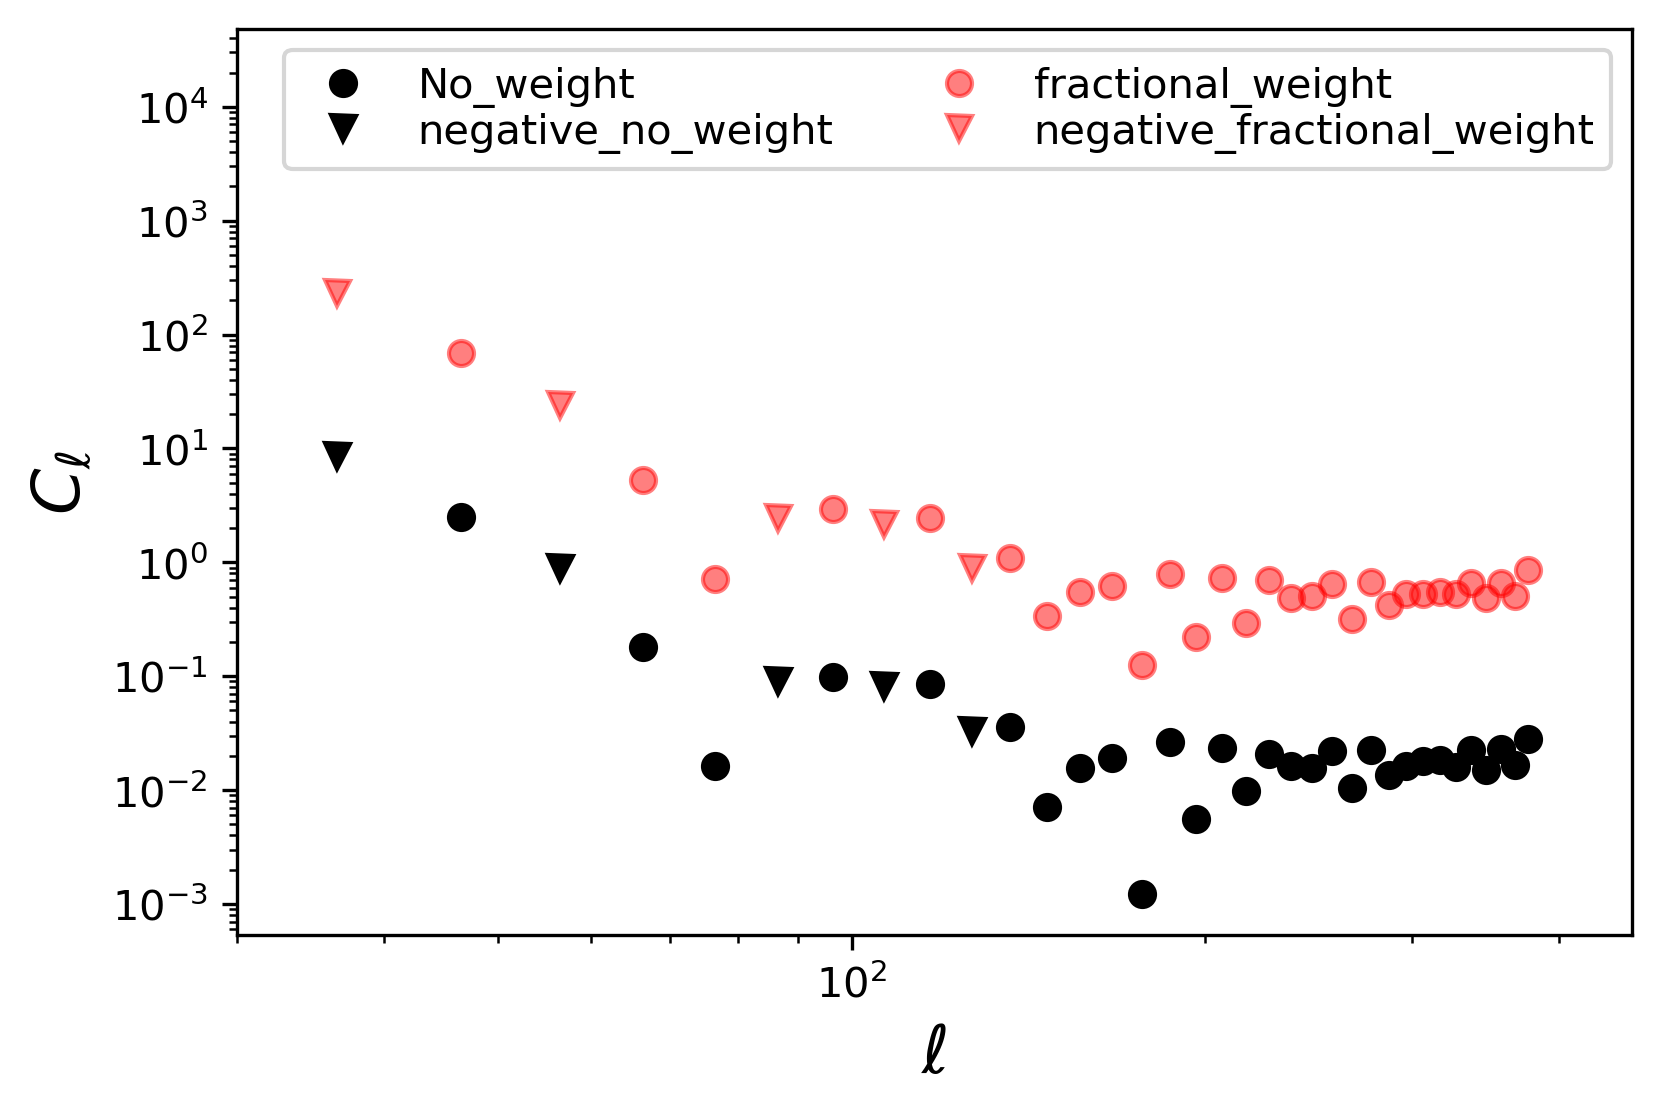

In [53]:
ell_arr = b.get_effective_ells()
figu=plt.figure(dpi=300)
ax = plt.axes()
plt.plot(ell_arr, cl_00[0]-s_00[0],linestyle='',marker='o', label='No_weight',color='black')
plt.plot(ell_arr, -1*(cl_00[0]-s_00[0]),linestyle='',marker='v', label='negative_no_weight',color='black')
plt.plot(ell_arr, cl_00_frac[0]-s_00_frac[0],linestyle='',marker='o', label='fractional_weight',color='red',alpha=0.5)
plt.plot(ell_arr, -1*(cl_00_frac[0]-s_00_frac[0]),linestyle='',marker='v', label='negative_fractional_weight',color='red',alpha=0.5)
# plt.plot(ell_arr, cl_00_frac[0],linestyle='',marker='o', label='fractional_weight',color='purple',alpha=0.5)
# plt.plot(ell_arr, -1*(cl_00_frac[0]),linestyle='',marker='v', label='negative_fractional_weight',color='purple',alpha=0.5)
# plt.plot(ell_arr, cl_overdensity[0],linestyle='',marker='o', label='overdensity_field',color='green',alpha=0.5)
# plt.plot(ell_arr, -1*(cl_overdensity[0]),linestyle='',marker='v', label='negative_overdensity_field',color='green',alpha=0.5)
# plt.plot(ell_arr, cl_00_rms[0]-s_00_rms[0],linestyle='',marker='o', label='rms_weight',color='blue',alpha=0.5)
# plt.plot(ell_arr, -1*(cl_00_rms[0]-s_00_rms[0]),linestyle='',marker='v', label='negative_rms_weight',color='blue',alpha=0.5)
# plt.plot(ell_arr, np.fabs(cl_02[0]), 'g-', label='TE')
# plt.plot(ell_arr, cl_22[0], 'b-', label='EE')
# plt.plot(ell_arr, cl_22[3], 'y-', label='BB')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.xlim(left=30)
# plt.xticks([40,50,60,70,80,100,200,300],[40,50,60,70,80,100,200,300])
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
# plt.ylim(top=10**2)
plt.show()
plt.rcParams['savefig.facecolor'] = "1"
# plt.savefig('../Otherwise_unclassified_plots/Cl_weighted.png')
plt.close()

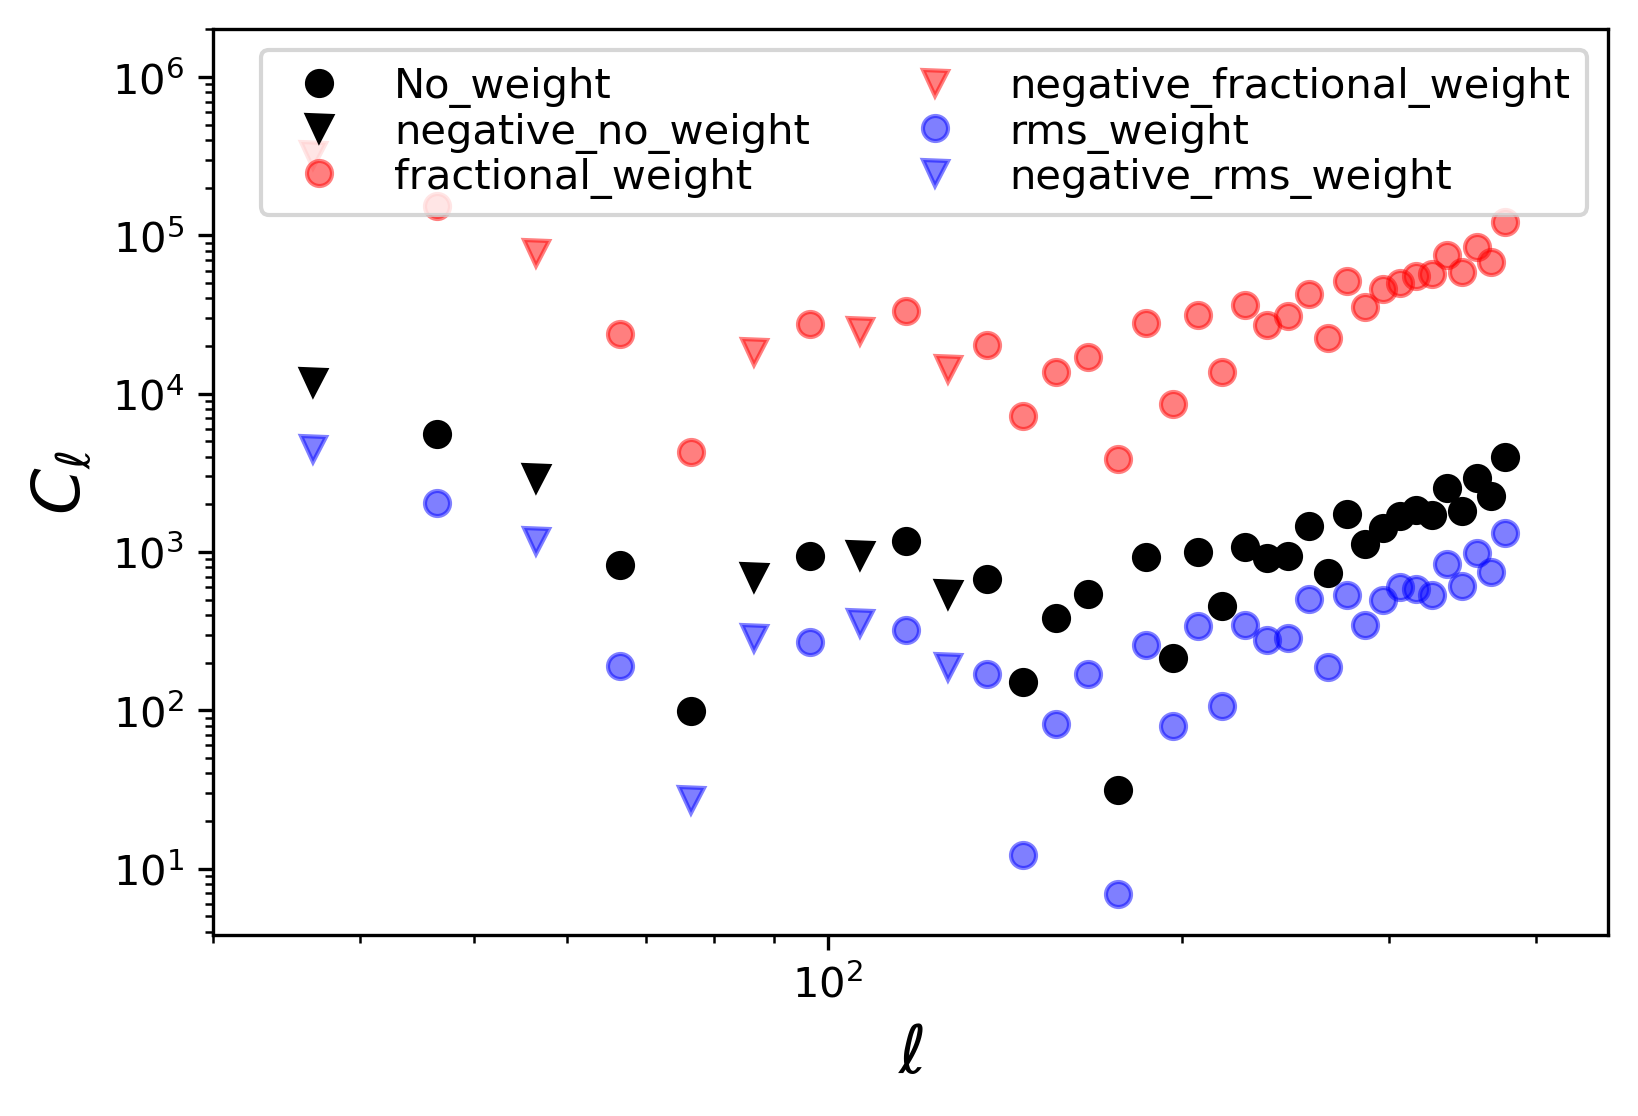

In [54]:
ell_arr = b.get_effective_ells()
figu=plt.figure(dpi=300)
ax = plt.axes()
plt.plot(ell_arr, ell_arr*(ell_arr+1)*cl_00[0],linestyle='',marker='o', label='No_weight',color='black')
plt.plot(ell_arr, ell_arr*(ell_arr+1)*-1*(cl_00[0]),linestyle='',marker='v', label='negative_no_weight',color='black')
plt.plot(ell_arr, ell_arr*(ell_arr+1)*cl_00_frac[0],linestyle='',marker='o', label='fractional_weight',color='red',alpha=0.5)
plt.plot(ell_arr, ell_arr*(ell_arr+1)*-1*(cl_00_frac[0]),linestyle='',marker='v', label='negative_fractional_weight',color='red',alpha=0.5)
plt.plot(ell_arr, ell_arr*(ell_arr+1)*cl_00_rms[0],linestyle='',marker='o', label='rms_weight',color='blue',alpha=0.5)
plt.plot(ell_arr, ell_arr*(ell_arr+1)*-1*(cl_00_rms[0]),linestyle='',marker='v', label='negative_rms_weight',color='blue',alpha=0.5)
# plt.plot(ell_arr, np.fabs(cl_02[0]), 'g-', label='TE')
# plt.plot(ell_arr, cl_22[0], 'b-', label='EE')
# plt.plot(ell_arr, cl_22[3], 'y-', label='BB')
plt.loglog()
# plt.fill_between([180/0.016],[10,10],color='grey',alpha=0.1)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.xlim(left=30)
# plt.xticks([40,50,60,70,80,100,200,300],[40,50,60,70,80,100,200,300])
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
# plt.ylim(top=10**2)
plt.show()